# Capacitated K-Center Clustering Algorithm - CORRECTED Implementation

### Fixes Applied:
1. **Replaced KMeans with vanilla K-Center** (Farthest-First Traversal)
2. **Added facility set F** as separate input (F = C, any client location can be a facility)
3. **Fixed Line 4**: R = {d(c,f) | c ∈ C, f ∈ F} (distances from clients to ALL facilities)
4. **Fixed Line 13**: F'ᵢ uses F (not S')
5. **Fixed Line 14**: Removed extra constraint in edge creation
6. **Fixed Line 16**: Returns actual facilities from F based on max-flow

## Section 1: Install Required Packages and Import Libraries

In [1]:
# Install required packages (suppress output with -q flag)
!pip install networkx matplotlib seaborn pandas numpy -q

# Import numerical computing library
import numpy as np

# Import data manipulation library
import pandas as pd

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import graph library for max-flow algorithms
import networkx as nx

# Import type hints for better code documentation
from typing import List, Dict, Tuple, Optional, Set

# Import warnings library to suppress unnecessary warnings
import warnings
warnings.filterwarnings('ignore')  # Suppress all warnings for cleaner output

# Set random seed for reproducibility across runs
np.random.seed(42)

print(" " * 20 + "All packages loaded successfully")
print(" " * 20 + "Distance unit: MILES")


                    All packages loaded successfully
                    Distance unit: MILES
                    Using CORRECTED Algorithm Implementation


## Section 2: Distance Calculation Functions

### These functions calculate geographic distances between points on Earth

In [2]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate great circle distance between two points on Earth.
    Uses the Haversine formula which accounts for Earth's curvature.

    Parameters:
    -----------
    lat1, lon1 : float
        Latitude and longitude of first point in decimal degrees
    lat2, lon2 : float
        Latitude and longitude of second point in decimal degrees

    Returns:
    --------
    distance : float
        Distance between the two points in MILES
    """
    # Convert all coordinates from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Calculate differences
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Apply Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # Earth's radius in MILES
    earth_radius_miles = 3959

    return c * earth_radius_miles


def compute_distance_matrix(points1, points2=None):
    """
    Compute pairwise distances between all points in two sets.
    Uses Haversine distance for geographic accuracy.

    Parameters:
    -----------
    points1 : numpy array of shape (n1, 2)
        First set of points with format [latitude, longitude]
    points2 : numpy array of shape (n2, 2), optional
        Second set of points. If None, computes distances within points1

    Returns:
    --------
    distances : numpy array of shape (n1, n2)
        Matrix where distances[i,j] = distance from points1[i] to points2[j] in MILES
    """
    if points2 is None:
        points2 = points1

    n1 = len(points1)
    n2 = len(points2)

    distances = np.zeros((n1, n2))

    for i in range(n1):
        for j in range(n2):
            distances[i, j] = haversine_distance(
                points1[i, 0], points1[i, 1],
                points2[j, 0], points2[j, 1]
            )

    return distances


print("Distance calculation functions defined")
print("  -> Using Haversine formula for geographic accuracy")
print("  -> All distances measured in MILES")

Distance calculation functions defined
  -> Using Haversine formula for geographic accuracy
  -> All distances measured in MILES


## Section 3: Partition Generation Function

### Algorithm Line 5: Generate all ways to distribute k facilities among τ centers

In [3]:
def generate_partitions(k: int, tau: int) -> List[List[int]]:
    """
    Generate all ways to partition k facilities among tau approximate centers.

    This implements Algorithm Line 5:
    "for each (k1, k2, ..., k_tau) such that sum(ki) = k"

    Parameters:
    -----------
    k : int
        Total number of facilities to place
    tau : int
        Number of approximate centers from initial clustering

    Returns:
    --------
    partitions : list of lists
        All valid partitions where each sums to k
    """
    if tau == 1:
        return [[k]]

    partitions = []
    for i in range(k + 1):
        for sub_partition in generate_partitions(k - i, tau - 1):
            partitions.append([i] + sub_partition)

    return partitions


print("Partition generation function defined")
print("\nExample: Partitioning 4 facilities among 2 centers:")
example_partitions = generate_partitions(4, 2)
print(f"  Partitions: {example_partitions}")
print(f"  All sum to 4: {all(sum(p) == 4 for p in example_partitions)}")

Partition generation function defined

Example: Partitioning 4 facilities among 2 centers:
  Partitions: [[0, 4], [1, 3], [2, 2], [3, 1], [4, 0]]
  All sum to 4: True


## Section 4: Vanilla K-Center Clustering (Farthest-First Traversal)

### Algorithm Lines 1-3: Compute initial approximate clustering
### CORRECTED: Uses K-Center instead of KMeans

In [4]:
def vanilla_k_center(C: np.ndarray, F: np.ndarray, k: int) -> Tuple[np.ndarray, np.ndarray, float, int]:
    """
    CORRECTED: Vanilla K-Center using Farthest-First Traversal.

    This is a 2-approximation algorithm for the metric k-center problem.
    Selects k centers from F that minimize the maximum distance from any client in C.

    Implements Algorithm Lines 1-3:
    1. S', sigma' <- a (1+epsilon)-approximate clustering on C, F, k
    2. r' <- radius induced by S', sigma'
    3. tau <- |S'|

    Parameters:
    -----------
    C : numpy array of shape (n, 2)
        Client locations as [latitude, longitude] pairs
    F : numpy array of shape (m, 2)
        Candidate facility locations as [latitude, longitude] pairs
    k : int
        Number of centers to select

    Returns:
    --------
    S_prime : numpy array of shape (k, 2)
        Selected center locations from F
    S_prime_indices : numpy array of shape (k,)
        Indices of selected centers in F
    r_prime : float
        Radius of clustering (max distance from any client to nearest center)
    tau : int
        Number of centers (equals k)
    """
    n_clients = len(C)
    n_facilities = len(F)

    # Compute distance matrix from all clients to all facilities
    dist_CF = compute_distance_matrix(C, F)

    # Initialize: track minimum distance from each client to any selected center
    min_dist_to_center = np.full(n_clients, np.inf)

    # Track which facilities are selected as centers
    selected_indices = []

    # Step 1: Select first center as the facility that minimizes max distance to any client
    # (Or simply pick the one closest to the centroid, or arbitrarily)
    # Here we pick the facility with minimum maximum distance to all clients
    max_dists = dist_CF.max(axis=0)  # Max distance from each facility to all clients
    first_center = np.argmin(max_dists)
    selected_indices.append(first_center)

    # Update minimum distances
    min_dist_to_center = np.minimum(min_dist_to_center, dist_CF[:, first_center])

    # Step 2: Greedily add k-1 more centers using farthest-first
    for _ in range(k - 1):
        # Find the client that is farthest from its nearest center
        farthest_client = np.argmax(min_dist_to_center)
        farthest_dist = min_dist_to_center[farthest_client]

        # Find the facility in F closest to this farthest client
        # (This ensures we're selecting from F, not arbitrary points)
        client_to_facilities = dist_CF[farthest_client, :]

        # Select facility not already chosen that is closest to the farthest client
        best_facility = -1
        best_dist = np.inf
        for f_idx in range(n_facilities):
            if f_idx not in selected_indices:
                if client_to_facilities[f_idx] < best_dist:
                    best_dist = client_to_facilities[f_idx]
                    best_facility = f_idx

        if best_facility == -1:
            # No more facilities available
            break

        selected_indices.append(best_facility)

        # Update minimum distances for all clients
        min_dist_to_center = np.minimum(min_dist_to_center, dist_CF[:, best_facility])

    # Extract selected centers
    S_prime_indices = np.array(selected_indices)
    S_prime = F[S_prime_indices]

    # Compute radius r' = max distance from any client to its nearest center
    r_prime = min_dist_to_center.max()

    # tau = number of centers
    tau = len(S_prime)

    return S_prime, S_prime_indices, r_prime, tau


print("Vanilla K-Center function defined (Farthest-First Traversal)")
print("  -> Provides 2-approximation guarantee")
print("  -> Selects centers from facility set F")
print("  -> Computes S' (centers), r' (radius), and tau (count)")

Vanilla K-Center function defined (Farthest-First Traversal)
  -> Provides 2-approximation guarantee
  -> Selects centers from facility set F
  -> Computes S' (centers), r' (radius), and tau (count)


## Section 5: Flow Network Construction

### Algorithm Lines 7-14: Build max-flow network
### CORRECTED: Uses facility set F properly, removes extra constraints

In [5]:
def build_flow_network(
    C: np.ndarray,
    F: np.ndarray,
    S_prime: np.ndarray,
    S_prime_indices: np.ndarray,
    capacity: int,
    r: float,
    r_prime: float,
    dist_CF: np.ndarray,
    dist_FS_prime: np.ndarray,
    partition: List[int]
) -> Tuple[nx.DiGraph, List[str], List[str], Dict[str, int]]:
    """
    CORRECTED: Build max-flow network for capacity-constrained facility assignment.

    Implements Algorithm Lines 7-14 CORRECTLY:
    - Line 7: V <- {s, t} union C
    - Line 8: V <- V union (ki copies of i-th facility of S')
    - Line 9: E <- edges from s to each client with weight 1
    - Line 10: E <- edges each facility to t with weight U
    - Line 11-14: For each center, add edges based on distance constraints

    FIXES:
    - Line 13: F'i uses F (potential facilities), not S'
    - Line 14: No extra constraint added - just pairs in C'i x F'i

    Parameters:
    -----------
    C : array (n_clients, 2)
        Client locations
    F : array (n_facilities, 2)
        ALL potential facility locations
    S_prime : array (tau, 2)
        Approximate center locations (subset of F)
    S_prime_indices : array (tau,)
        Indices of S_prime centers in F
    capacity : int
        Maximum clients per facility (U in algorithm)
    r : float
        Current radius being tested
    r_prime : float
        Initial clustering radius
    dist_CF : array (n_clients, n_facilities)
        Distances from clients to ALL facilities in F
    dist_FS_prime : array (n_facilities, tau)
        Distances from ALL facilities in F to centers in S'
    partition : list of tau integers
        partition[i] = number of facility copies for center i

    Returns:
    --------
    G : NetworkX DiGraph
        Flow network with capacity constraints
    client_nodes : list
        Names of client nodes in graph
    facility_nodes : list
        Names of facility nodes (representing actual F locations)
    facility_node_to_F_idx : dict
        Maps facility node names to indices in F
    """
    n_clients = len(C)
    n_facilities = len(F)
    tau = len(S_prime)

    # Create directed graph for max-flow
    G = nx.DiGraph()

    # Algorithm Line 7: V <- {s, t} union C
    source = 'source'
    sink = 'sink'
    G.add_node(source)
    G.add_node(sink)

    # Add client nodes
    client_nodes = [f'c_{i}' for i in range(n_clients)]
    G.add_nodes_from(client_nodes)

    # Algorithm Line 8: V <- V union (ki copies of i-th facility of S')
    # CORRECTED: We need to track which facilities from F are used
    # For each center S'[i], we allow ki facilities from F'i (facilities near S'[i])

    facility_nodes = []
    facility_node_to_F_idx = {}  # Maps node name to index in F
    facility_node_to_center = {}  # Maps node name to which S' center it belongs to

    # For each approximate center, find eligible facilities from F
    # Line 13: F'i <- {f in F | d(f, f'i) <= r'}
    facilities_per_center = []  # List of lists: facilities_per_center[i] = F'i indices

    for s_idx in range(tau):
        # CORRECTED Line 13: Find facilities from F within r' of this center
        # dist_FS_prime[:, s_idx] = distance from each facility in F to S'[s_idx]
        F_prime_i_indices = np.where(dist_FS_prime[:, s_idx] <= r_prime)[0]
        facilities_per_center.append(F_prime_i_indices)

        # Create ki copies/slots for facilities near this center
        num_copies = partition[s_idx]
        for copy_idx in range(num_copies):
            # Each copy represents a "slot" that can be filled by any facility in F'i
            node_name = f'f_center{s_idx}_slot{copy_idx}'
            facility_nodes.append(node_name)
            facility_node_to_center[node_name] = s_idx
            # Note: actual F index will be determined by max-flow assignment

    G.add_nodes_from(facility_nodes)

    # Algorithm Line 9: E <- edges from s to each client with weight 1
    for client_node in client_nodes:
        G.add_edge(source, client_node, capacity=1)

    # Algorithm Line 10: E <- edges each facility to t with weight U
    for facility_node in facility_nodes:
        G.add_edge(facility_node, sink, capacity=capacity)

    # Algorithm Lines 11-14: Add edges between clients and facilities
    for s_idx in range(tau):
        # Line 12: C'i <- {c in C | d(c, f'i) <= r + r'}
        # Distance from clients to this center S'[s_idx]
        center_idx_in_F = S_prime_indices[s_idx]
        dist_C_to_center = dist_CF[:, center_idx_in_F]
        C_prime_i = np.where(dist_C_to_center <= r + r_prime)[0]

        # Line 13: F'i (already computed above)
        F_prime_i = facilities_per_center[s_idx]

        # Line 14: E <- edges for each pair of c in C'i and f in F'i with weight 1
        # CORRECTED: Add edges for ALL pairs in C'i x F'i, NO extra constraint

        # Get facility slots for this center
        center_facility_nodes = [fn for fn in facility_nodes
                                  if facility_node_to_center[fn] == s_idx]

        for c_idx in C_prime_i:
            client_node = client_nodes[c_idx]

            # Connect to all facility slots for this center
            # (In the flow, each slot can serve up to U clients)
            for facility_node in center_facility_nodes:
                # Add edge with capacity 1 (client uses at most 1 facility)
                if not G.has_edge(client_node, facility_node):
                    G.add_edge(client_node, facility_node, capacity=1)

    return G, client_nodes, facility_nodes, facility_node_to_center, facilities_per_center


print("Flow network construction function defined (CORRECTED)")
print("  -> Uses facility set F properly (Line 13 fix)")
print("  -> No extra distance constraint in Line 14")
print("  -> Tracks facility indices for proper output")

Flow network construction function defined (CORRECTED)
  -> Uses facility set F properly (Line 13 fix)
  -> No extra distance constraint in Line 14
  -> Tracks facility indices for proper output


## Section 6: Main Capacitated K-Center Algorithm

### CORRECTED: Complete implementation with all fixes applied

In [6]:
def capacitated_k_center(
    C: np.ndarray,
    F: np.ndarray,
    k: int,
    capacity: int,
    max_partitions: int = 50
) -> Optional[Dict]:
    """
    CORRECTED IMPLEMENTATION: Algorithm 1 - Euclidean-capacitated-k-center

    Finds optimal placement of k facilities (from set F) with capacity constraints
    to serve all clients in C. Minimizes the maximum distance from any client
    to its assigned facility.

    CORRECTIONS APPLIED:
    1. Uses vanilla K-Center (not KMeans) for initial clustering
    2. Takes both C (clients) and F (facilities) as separate inputs
    3. R = {d(c,f) | c in C, f in F} - correct distance set
    4. F'i uses F, not S'
    5. No extra constraint in edge creation
    6. Returns actual facilities from F based on max-flow

    Parameters:
    -----------
    C : numpy array of shape (n, 2)
        Client locations as [latitude, longitude]
    F : numpy array of shape (m, 2)
        Candidate facility locations as [latitude, longitude]
    k : int
        Number of facilities to place
    capacity : int
        Maximum number of clients each facility can serve (U in algorithm)
    max_partitions : int, default=50
        Maximum number of partitions to test (None = test all)

    Returns:
    --------
    best_solution : dict or None
        Dictionary containing:
        - 'facilities': Locations of k opened facilities (from F)
        - 'facility_indices': Indices of opened facilities in F
        - 'assignments': Client-to-facility mapping
        - 'radius': Optimal radius in MILES
        - 'partition': Facility distribution used
        - 'capacity': Capacity per facility
        Returns None if no feasible solution exists
    """
    n = len(C)  # Number of clients
    m = len(F)  # Number of candidate facilities

    print(f"\n{'='*80}")
    print(f"{'CAPACITATED K-CENTER ALGORITHM (CORRECTED)':^80}")
    print(f"{'='*80}")
    print(f"  Clients: {n} | Candidate Facilities: {m} | k: {k} | Capacity: {capacity}")
    print(f"  Distance unit: MILES")
    print(f"{'='*80}\n")

    # =========================================================================
    # ALGORITHM LINES 1-3: Initial Clustering using Vanilla K-Center
    # =========================================================================
    print("[Step 1/5] Computing initial clustering (Algorithm Lines 1-3)...")
    print("           Using Vanilla K-Center (Farthest-First Traversal)")

    S_prime, S_prime_indices, r_prime, tau = vanilla_k_center(C, F, k)

    print(f"  -> Initial radius r' = {r_prime:.3f} miles")
    print(f"  -> tau (number of approximate centers) = {tau}")
    print(f"  -> Center indices in F: {S_prime_indices.tolist()}")

    # =========================================================================
    # ALGORITHM LINE 4: Build Distance Set R
    # CORRECTED: R = {d(c,f) | c in C, f in F}
    # =========================================================================
    print(f"\n[Step 2/5] Computing distance set R (Algorithm Line 4)...")
    print("           CORRECTED: R = distances from C to F (not C to S')")

    # Compute distance from each client to each facility in F
    dist_CF = compute_distance_matrix(C, F)

    # Compute distance from each facility in F to each center in S'
    dist_FS_prime = compute_distance_matrix(F, S_prime)

    # CORRECTED: R contains all unique client-to-facility distances
    R = np.unique(dist_CF.flatten())
    R = R[R > 0]  # Remove zero distances
    R = np.sort(R)  # Sort ascending

    print(f"  -> |R| = {len(R)} unique client-facility distances")
    print(f"  -> Range: [{R.min():.3f}, {R.max():.3f}] miles")

    # =========================================================================
    # ALGORITHM LINE 5: Generate All Partitions
    # =========================================================================
    print(f"\n[Step 3/5] Generating partitions (Algorithm Line 5)...")

    all_partitions = generate_partitions(k, tau)

    # Sort partitions: prefer balanced distributions (fewer zeros)
    all_partitions.sort(key=lambda p: (sum(1 for x in p if x == 0), -min(p) if min(p) > 0 else float('inf')))

    if max_partitions and len(all_partitions) > max_partitions:
        partitions_to_test = all_partitions[:max_partitions]
        print(f"  -> Generated {len(all_partitions)} total, testing {len(partitions_to_test)}")
    else:
        partitions_to_test = all_partitions
        print(f"  -> Testing all {len(partitions_to_test)} partitions")

    # =========================================================================
    # ALGORITHM LINES 5-17: Search Over Partitions and Radii
    # =========================================================================
    print(f"\n[Step 4/5] Searching for optimal solution (Algorithm Lines 5-17)...")

    best_solution = None
    best_radius = float('inf')
    best_partition = None

    for partition_idx, partition in enumerate(partitions_to_test):
        if partition_idx % max(1, len(partitions_to_test) // 5) == 0:
            print(f"  Progress: Partition {partition_idx+1}/{len(partitions_to_test)}: {partition}")

        # Check capacity feasibility
        total_capacity = sum(partition) * capacity
        if total_capacity < n:
            continue

        # Binary search for optimal radius
        left, right = 0, len(R) - 1
        partition_best_radius = float('inf')
        partition_best_solution = None

        while left <= right:
            mid = (left + right) // 2
            r = R[mid]

            # Build flow network (CORRECTED)
            try:
                G, client_nodes, facility_nodes, fac_to_center, fac_per_center = build_flow_network(
                    C, F, S_prime, S_prime_indices, capacity,
                    r, r_prime, dist_CF, dist_FS_prime, partition
                )

                # Algorithm Line 15: Run max-flow
                flow_value, flow_dict = nx.maximum_flow(G, 'source', 'sink')

                if flow_value >= n:
                    # Feasible! Extract assignments

                    # Algorithm Line 16: Assign clients and open facilities
                    # CORRECTED: Track which actual facilities from F are used
                    assignments = {}
                    used_facility_slots = set()

                    for c_idx, client_node in enumerate(client_nodes):
                        if client_node in flow_dict:
                            for facility_node, flow in flow_dict[client_node].items():
                                if flow > 0 and facility_node.startswith('f_'):
                                    # Get center index
                                    center_idx = fac_to_center[facility_node]
                                    used_facility_slots.add(facility_node)

                                    # Assign client to this center's representative facility
                                    # (The actual facility from F closest to center)
                                    assignments[c_idx] = center_idx
                                    break

                    # Determine which facilities from F to open
                    # For each used slot, pick the best facility from F'i
                    opened_facilities = []
                    opened_facility_indices = []

                    for s_idx in range(tau):
                        if partition[s_idx] > 0:
                            # Find best facility in F'i for this center
                            F_prime_i = fac_per_center[s_idx]
                            if len(F_prime_i) > 0:
                                # Pick facility closest to center
                                best_f_idx = F_prime_i[np.argmin(dist_FS_prime[F_prime_i, s_idx])]
                                opened_facilities.append(F[best_f_idx])
                                opened_facility_indices.append(best_f_idx)

                    partition_best_radius = r
                    partition_best_solution = {
                        'facilities': np.array(opened_facilities) if opened_facilities else S_prime.copy(),
                        'facility_indices': opened_facility_indices if opened_facility_indices else S_prime_indices.tolist(),
                        'assignments': assignments,
                        'radius': r,
                        'flow_value': flow_value,
                        'capacity': capacity,
                        'partition': partition.copy()
                    }

                    right = mid - 1  # Try smaller radius
                else:
                    left = mid + 1  # Need larger radius

            except Exception as e:
                left = mid + 1
                continue

        # Algorithm Line 17: Keep best solution
        if partition_best_solution and partition_best_radius < best_radius:
            best_radius = partition_best_radius
            best_solution = partition_best_solution
            best_partition = partition
            print(f"    -> NEW BEST! Partition {partition}, radius {best_radius:.3f} miles")

    # =========================================================================
    # Report Results
    # =========================================================================
    print(f"\n[Step 5/5] Optimization complete")

    if best_solution:
        print(f"  -> Best partition: {best_partition}")
        print(f"  -> Best radius: {best_radius:.3f} miles")
        print(f"  -> All {n} clients successfully assigned")
        print(f"  -> Facilities opened from F: {best_solution['facility_indices']}")
    else:
        print(f"  -> No feasible solution found")
        print(f"  -> Try increasing capacity or k")

    print(f"\n{'='*80}\n")

    return best_solution


print("Main capacitated k-center algorithm defined (CORRECTED)")
print("  -> Uses vanilla K-Center for initial clustering")
print("  -> Properly uses both C and F sets")
print("  -> Returns facilities selected from F")

Main capacitated k-center algorithm defined (CORRECTED)
  -> Uses vanilla K-Center for initial clustering
  -> Properly uses both C and F sets
  -> Returns facilities selected from F


## Section 7: Data Loading

### Load your EMR_Incidents.csv file

In [7]:
# Try to load from local file first, otherwise use Colab upload
try:
    df = pd.read_csv("EMR_Incidents.csv")
    print("Loaded EMR_Incidents.csv from local directory")
except FileNotFoundError:
    print("Please UPLOAD your EMR_Incidents.csv file...\n")
    from google.colab import files
    uploaded = files.upload()
    df = pd.read_csv("EMR_Incidents.csv")

print(f"Initial dataset: {len(df)} records")

# Remove rows with missing coordinates
df = df.dropna(subset=["Latitude", "Longitude"])
print(f"After removing missing coordinates: {len(df)} records")

# Filter to valid NYC geographic bounds
lat_min, lat_max = 40.4, 41.0
lon_min, lon_max = -74.3, -73.6

df = df[(df["Latitude"].between(lat_min, lat_max)) &
        (df["Longitude"].between(lon_min, lon_max))]

print(f"After filtering to NYC bounds: {len(df)} records")

# Extract coordinates
X = df[["Latitude", "Longitude"]].values

# Define C (clients) and F (candidate facilities)
# In this case, F = C (any client location can be a facility)
C = X.copy()  # Clients
F = X.copy()  # Candidate facilities (same as clients)

print(f"\nData loaded:")
print(f"  C (clients): {len(C)} locations")
print(f"  F (candidate facilities): {len(F)} locations")
print(f"  Note: F = C (any client location can be a facility)")

Please UPLOAD your EMR_Incidents.csv file...



Saving EMR_Incidents.csv to EMR_Incidents.csv
Initial dataset: 1000 records
After removing missing coordinates: 873 records
After filtering to NYC bounds: 873 records

Data loaded:
  C (clients): 873 locations
  F (candidate facilities): 873 locations
  Note: F = C (any client location can be a facility)


## Section 8: Run the CORRECTED Algorithm

In [8]:
# ==================== ALGORITHM PARAMETERS ====================

K = 5              # Number of facilities to place
CAPACITY = 200     # Maximum clients per facility
MAX_PARTITIONS = 30  # Maximum partitions to test

# ==============================================================

print(f"{'='*80}")
print(f"{'EXPERIMENT CONFIGURATION':^80}")
print(f"{'='*80}")
print(f"  Total clients |C|: {len(C)}")
print(f"  Candidate facilities |F|: {len(F)}")
print(f"  k (facilities to open): {K}")
print(f"  Capacity per facility: {CAPACITY} clients")
print(f"  Total capacity: {K * CAPACITY} clients")
print(f"  Max partitions to test: {MAX_PARTITIONS}")
print(f"{'='*80}\n")

# Check feasibility
if K * CAPACITY < len(C):
    print(f"WARNING: Total capacity ({K * CAPACITY}) < clients ({len(C)})")
    print(f"Solution may not be feasible!\n")

# Run the CORRECTED algorithm
solution = capacitated_k_center(
    C=C,
    F=F,
    k=K,
    capacity=CAPACITY,
    max_partitions=MAX_PARTITIONS
)

                            EXPERIMENT CONFIGURATION                            
  Total clients |C|: 873
  Candidate facilities |F|: 873
  k (facilities to open): 5
  Capacity per facility: 200 clients
  Total capacity: 1000 clients
  Max partitions to test: 30


                   CAPACITATED K-CENTER ALGORITHM (CORRECTED)                   
  Clients: 873 | Candidate Facilities: 873 | k: 5 | Capacity: 200
  Distance unit: MILES

[Step 1/5] Computing initial clustering (Algorithm Lines 1-3)...
           Using Vanilla K-Center (Farthest-First Traversal)
  -> Initial radius r' = 9.507 miles
  -> tau (number of approximate centers) = 5
  -> Center indices in F: [142, 534, 39, 492, 306]

[Step 2/5] Computing distance set R (Algorithm Line 4)...
           CORRECTED: R = distances from C to F (not C to S')
  -> |R| = 294528 unique client-facility distances
  -> Range: [0.000, 34.012] miles

[Step 3/5] Generating partitions (Algorithm Line 5)...
  -> Generated 126 total, testing 30

[Step

## Section 9: Analyze Results

In [9]:
if solution:
    # Compute distance statistics
    distances = []
    facilities_used = {}

    for c_idx, center_idx in solution['assignments'].items():
        # Find the opened facility for this center
        if center_idx < len(solution['facilities']):
            facility = solution['facilities'][center_idx]
        else:
            facility = solution['facilities'][0]  # Fallback

        dist = haversine_distance(
            C[c_idx, 0], C[c_idx, 1],
            facility[0], facility[1]
        )
        distances.append(dist)

        if center_idx not in facilities_used:
            facilities_used[center_idx] = 0
        facilities_used[center_idx] += 1

    print("\n" + "="*80)
    print(f"{'SOLUTION METRICS':^80}")
    print("="*80)

    print(f"\n  Distance Statistics (in MILES):")
    print(f"    Average distance: {np.mean(distances):.3f} miles")
    print(f"    Maximum distance: {np.max(distances):.3f} miles")
    print(f"    Minimum distance: {np.min(distances):.3f} miles")
    print(f"    Std deviation: {np.std(distances):.3f} miles")

    print(f"\n  Facility Information:")
    print(f"    Partition used: {solution['partition']}")
    print(f"    Facilities opened from F: {solution['facility_indices']}")
    print(f"    Total facilities: {len(solution['facilities'])}")

    print(f"\n  Assignment Statistics:")
    print(f"    Clients assigned: {len(solution['assignments'])}/{len(C)}")

    print(f"\n  Per-Facility Breakdown:")
    print(f"    {'Facility':<12} {'Clients':<10} {'% Capacity':<12}")
    print(f"    {'-'*40}")
    for f_idx in sorted(facilities_used.keys()):
        count = facilities_used[f_idx]
        pct_cap = (count / CAPACITY) * 100
        print(f"    Center {f_idx:<5} {count:>4} clients   {pct_cap:>5.1f}%")

    print("\n" + "="*80)

else:
    print("\nNo feasible solution found.")
    print("Try increasing K or CAPACITY.")


                                SOLUTION METRICS                                

  Distance Statistics (in MILES):
    Average distance: 9.877 miles
    Maximum distance: 14.605 miles
    Minimum distance: 0.000 miles
    Std deviation: 3.644 miles

  Facility Information:
    Partition used: [1, 1, 1, 1, 1]
    Facilities opened from F: [np.int64(142), np.int64(534), np.int64(39), np.int64(492), np.int64(306)]
    Total facilities: 5

  Assignment Statistics:
    Clients assigned: 873/873

  Per-Facility Breakdown:
    Facility     Clients    % Capacity  
    ----------------------------------------
    Center 0      200 clients   100.0%
    Center 1       73 clients    36.5%
    Center 2      200 clients   100.0%
    Center 3      200 clients   100.0%
    Center 4      200 clients   100.0%



## Section 10: Visualization

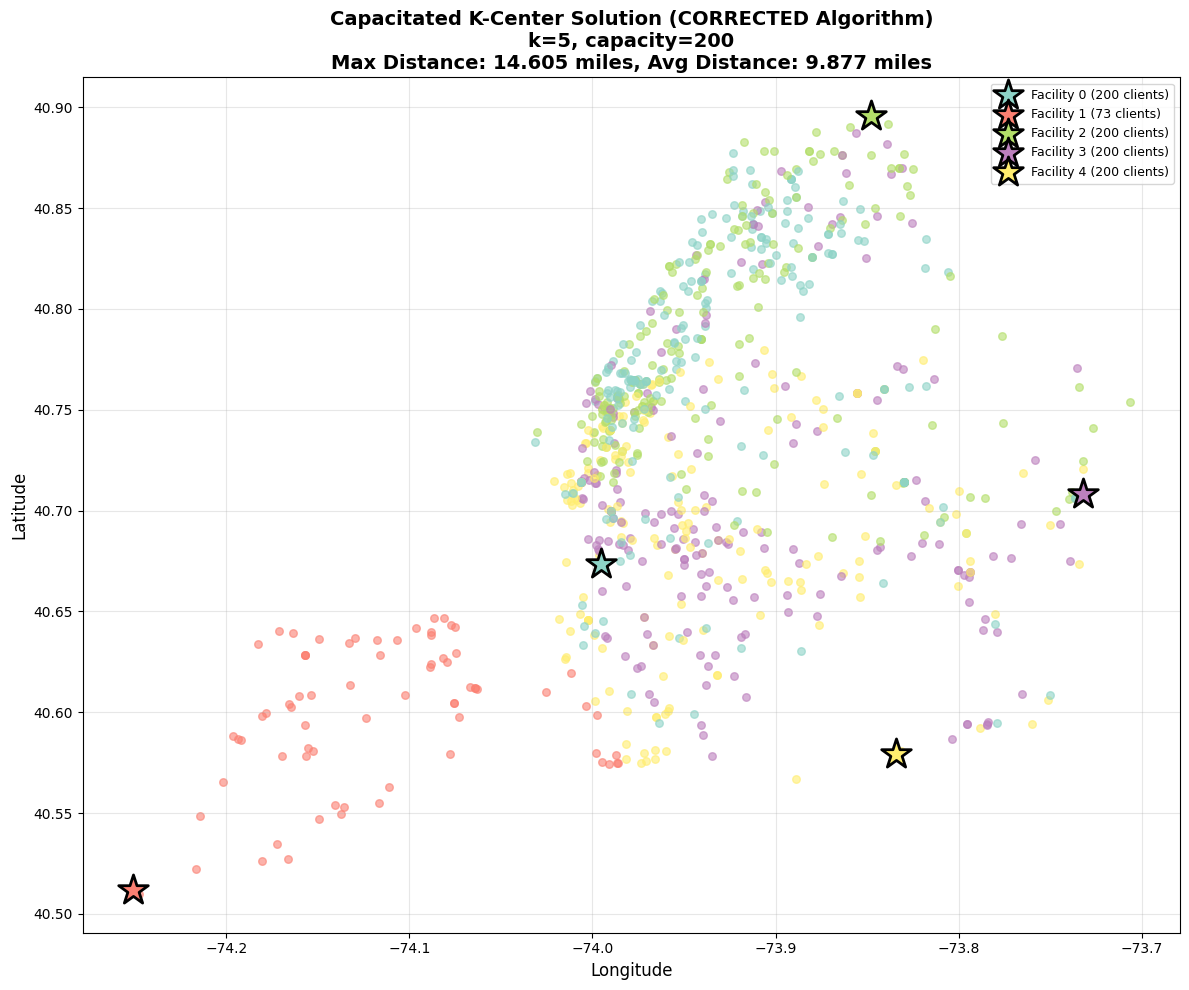


Visualization complete!


In [10]:
if solution:
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))

    num_facilities = len(solution['facilities'])
    colors = plt.cm.Set3(np.linspace(0, 1, max(num_facilities, 1)))

    # Plot clients colored by assigned facility
    for c_idx, center_idx in solution['assignments'].items():
        color_idx = min(center_idx, len(colors) - 1)
        ax.scatter(
            C[c_idx, 1], C[c_idx, 0],
            c=[colors[color_idx]],
            s=30, alpha=0.6
        )

    # Plot facilities
    for f_idx, facility in enumerate(solution['facilities']):
        count = facilities_used.get(f_idx, 0)
        ax.scatter(
            facility[1], facility[0],
            c=[colors[f_idx]],
            s=500, marker='*',
            edgecolors='black', linewidths=2,
            label=f'Facility {f_idx} ({count} clients)',
            zorder=5
        )

    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)

    title = (
        f'Capacitated K-Center Solution (CORRECTED Algorithm)\n'
        f'k={K}, capacity={CAPACITY}\n'
        f'Max Distance: {np.max(distances):.3f} miles, '
        f'Avg Distance: {np.mean(distances):.3f} miles'
    )
    ax.set_title(title, fontsize=14, fontweight='bold')

    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\nVisualization complete!")
else:
    print("No solution to visualize.")

## Section 11: Comparison - Basic K-Center vs Capacitated K-Center

K-CENTER COMPARISON (UNCAPACITATED vs CAPACITATED)

[1/2] Running Basic K-Center (Uncapacitated)...
  Max Distance: 10.508 mi
  Avg Distance: 4.574 mi

[2/2] Capacitated K-Center results (from above):
  Max Distance: 14.605 mi
  Avg Distance: 9.877 mi


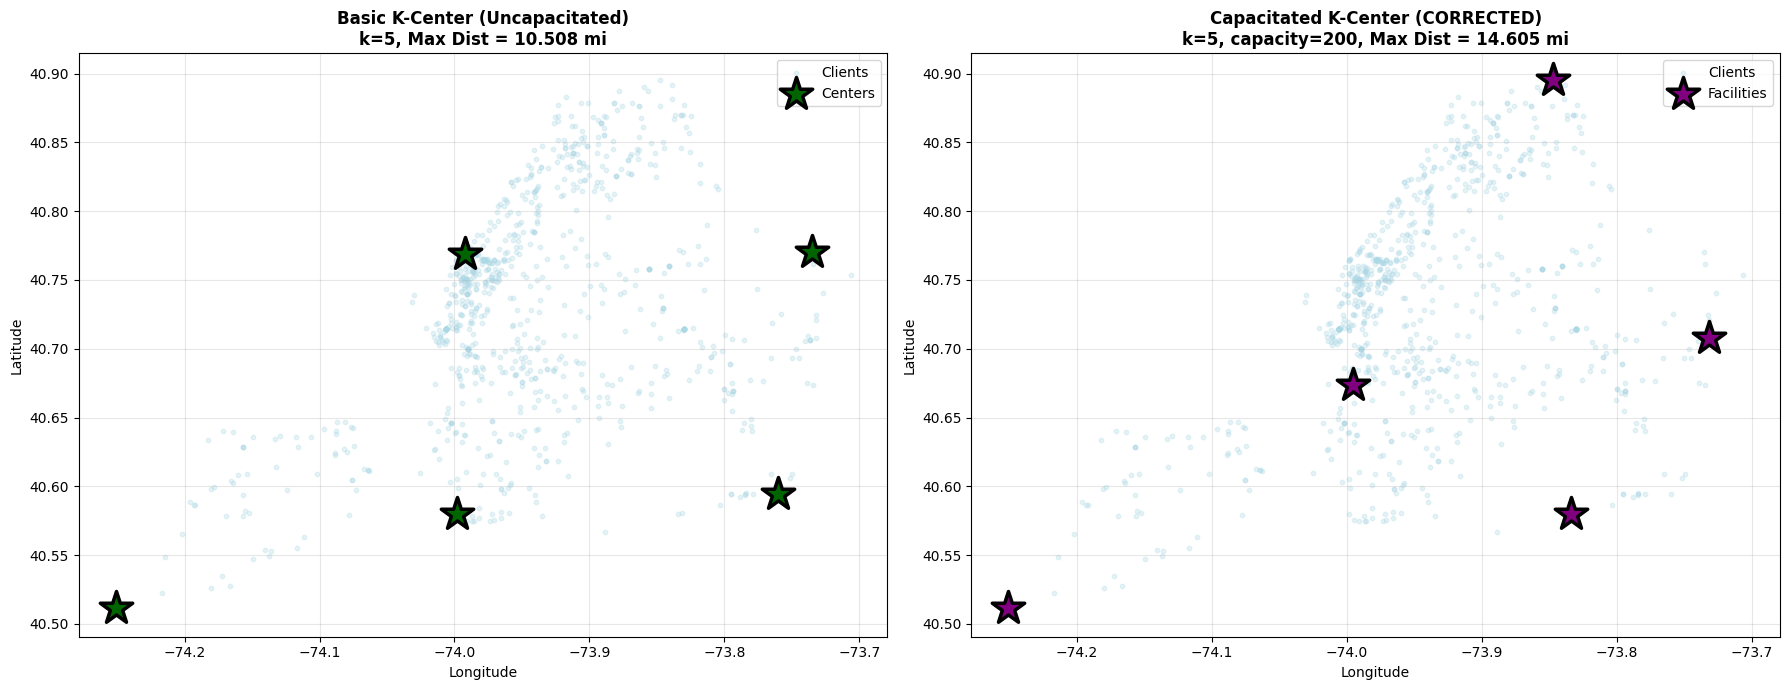


Saved: centers_comparison_corrected.png

                               COMPARISON SUMMARY                               

Algorithm                           Max Dist        Avg Dist       
-----------------------------------------------------------------
Basic K-Center (Uncapacitated)          10.508 mi      4.574 mi
Capacitated K-Center (CORRECTED)        14.605 mi      9.877 mi



In [11]:
def basic_k_center_greedy(points, k):
    """
    Greedy 2-approximation algorithm for uncapacitated k-center.
    Uses Farthest-First Traversal.
    """
    n = len(points)

    # Start with first point
    centers_indices = [0]
    centers = [points[0]]

    # Greedily add farthest points
    for _ in range(k - 1):
        max_min_dist = -1
        farthest_idx = -1

        for i in range(n):
            min_dist = float('inf')
            for center_idx in centers_indices:
                dist = haversine_distance(
                    points[i, 0], points[i, 1],
                    points[center_idx, 0], points[center_idx, 1]
                )
                min_dist = min(min_dist, dist)

            if min_dist > max_min_dist:
                max_min_dist = min_dist
                farthest_idx = i

        centers_indices.append(farthest_idx)
        centers.append(points[farthest_idx])

    centers = np.array(centers)

    # Assign each point to nearest center
    labels = np.zeros(n, dtype=int)
    distances = np.zeros(n)

    for i in range(n):
        min_dist = float('inf')
        nearest = 0

        for j, center_idx in enumerate(centers_indices):
            dist = haversine_distance(
                points[i, 0], points[i, 1],
                points[center_idx, 0], points[center_idx, 1]
            )
            if dist < min_dist:
                min_dist = dist
                nearest = j

        labels[i] = nearest
        distances[i] = min_dist

    return centers, labels, distances, centers_indices


# Run comparison
print("=" * 80)
print("K-CENTER COMPARISON (UNCAPACITATED vs CAPACITATED)")
print("=" * 80)

print("\n[1/2] Running Basic K-Center (Uncapacitated)...")
kcenter_centers, kcenter_labels, kcenter_distances, kcenter_indices = basic_k_center_greedy(C, K)

print(f"  Max Distance: {np.max(kcenter_distances):.3f} mi")
print(f"  Avg Distance: {np.mean(kcenter_distances):.3f} mi")

print("\n[2/2] Capacitated K-Center results (from above):")
if solution:
    print(f"  Max Distance: {np.max(distances):.3f} mi")
    print(f"  Avg Distance: {np.mean(distances):.3f} mi")
else:
    print("  No feasible solution")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Left: Basic K-Center
axes[0].scatter(C[:, 1], C[:, 0], c='lightblue', s=10, alpha=0.3, label='Clients')
axes[0].scatter(kcenter_centers[:, 1], kcenter_centers[:, 0],
                c='darkgreen', s=600, marker='*', edgecolors='black',
                linewidths=2.5, zorder=10, label='Centers')
axes[0].set_title(f"Basic K-Center (Uncapacitated)\nk={K}, Max Dist = {np.max(kcenter_distances):.3f} mi",
                  fontweight='bold')
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: Capacitated K-Center
if solution:
    axes[1].scatter(C[:, 1], C[:, 0], c='lightblue', s=10, alpha=0.3, label='Clients')
    axes[1].scatter(solution['facilities'][:, 1], solution['facilities'][:, 0],
                    c='purple', s=600, marker='*', edgecolors='black',
                    linewidths=2.5, zorder=10, label='Facilities')
    axes[1].set_title(f"Capacitated K-Center (CORRECTED)\nk={K}, capacity={CAPACITY}, Max Dist = {np.max(distances):.3f} mi",
                      fontweight='bold')
else:
    axes[1].text(0.5, 0.5, "No Feasible Solution", transform=axes[1].transAxes,
                 ha='center', va='center', fontsize=14)
    axes[1].set_title(f"Capacitated K-Center\nk={K}, capacity={CAPACITY}", fontweight='bold')

axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("centers_comparison_corrected.png", dpi=300, bbox_inches="tight")
plt.show()

print("\nSaved: centers_comparison_corrected.png")

# Summary table
print("\n" + "=" * 80)
print(f"{'COMPARISON SUMMARY':^80}")
print("=" * 80)
print(f"\n{'Algorithm':<35} {'Max Dist':<15} {'Avg Dist':<15}")
print("-" * 65)
print(f"{'Basic K-Center (Uncapacitated)':<35} {np.max(kcenter_distances):>10.3f} mi {np.mean(kcenter_distances):>10.3f} mi")
if solution:
    print(f"{'Capacitated K-Center (CORRECTED)':<35} {np.max(distances):>10.3f} mi {np.mean(distances):>10.3f} mi")
print("\n" + "=" * 80)